In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
import pickle

import IPython.display as ipd
import librosa
import librosa.display

from glob import glob
from dotenv import load_dotenv
from scipy.stats import norm
from my_functions.my_fun import *

# Cargando la metadata y audios

Cargar archivo de variables de entrono

In [2]:
load_dotenv()

True

Cargar los metadatos de los audios que poseen anotaciones, además de cargar también en una lista los nombres de los archivos de audio existentes

In [3]:
AUDIO_DIR = os.getenv('PMEMO_AUDIO')
aux_dir = os.getenv('PMEMO_META')
pmemo_metadata_dir = f"{aux_dir.split('.')[0]}_total.csv"

In [4]:
#Comprobar que los archivos existan

if os.path.exists(AUDIO_DIR):
    print("El directorio de audios existe")
else:
    print("El directorio de audios no existe")
    
if os.path.exists(pmemo_metadata_dir):
    print("El archivo de metada existe")
else:
    print("El archivo de metada no existe")

El directorio de audios existe
El archivo de metada existe


In [5]:
pmemo_metadata = pd.read_csv(pmemo_metadata_dir)
pmemo_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   musicId            767 non-null    int64  
 1   fileName           767 non-null    object 
 2   title              767 non-null    object 
 3   artist             767 non-null    object 
 4   album              760 non-null    object 
 5   duration           767 non-null    float64
 6   chorus_start_time  767 non-null    object 
 7   chorus_end_time    767 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 48.1+ KB


In [6]:
audios_list = os.listdir(AUDIO_DIR)
if os.path.exists(os.path.join(AUDIO_DIR,
                               audios_list[0])):
    print(f"el archivo {audios_list[0]} existe")

el archivo 1.mp3 existe


Cuando se trabaja con anotaciones dinamicas los audios fueron segmentados en fragmentos de 0.5 segundos, pero la segmentacion toma desde el segundo 15.5 y segmenta hasta el final del clip de audio, hay clips que tienen más segementos que otros

In [7]:
pmemo_metadata.head(5)

,musicId,fileName,title,artist,album,duration,chorus_start_time,chorus_end_time
0,1,1.mp3,Good Drank,2 Chainz,"Def Jam Presents: Direct Deposit, Vol. 2",32.10,02:35,03:05
1,4,4.mp3,X Bitch (feat. Future),21 Savage,Savage Mode,28.09,03:00,03:26
2,5,5.mp3,No Heart,21 Savage,Savage Mode,84.23,00:41,02:03
3,6,6.mp3,Red Opps,21 Savage,Red Opps,29.53,02:16,02:44
4,7,7.mp3,Girls Talk Boys,5 Seconds Of Summer,Ghostbusters (Original Motion Picture Soundtrack),29.11,02:30,02:57


In [8]:
audio_files = glob(f"{AUDIO_DIR}\\*.mp3")

In [9]:
random_idx = np.random.randint(low=0,high=len(audio_files))
aux_audio_file = audio_files[random_idx].split('\\')[-1]
display(pmemo_metadata.loc[pmemo_metadata['fileName'] == aux_audio_file])

,musicId,fileName,title,artist,album,duration,chorus_start_time,chorus_end_time
264,348,348.mp3,Ivy,Frank Ocean,Blonde,69.2,02:39,03:46


In [10]:
ipd.Audio(audio_files[random_idx])

In [11]:
y,sr = librosa.load(audio_files[random_idx])
print(f'y:{y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y:[2.1684043e-17 2.7538735e-17 4.7704896e-17 1.8214596e-17 2.1250363e-17
 3.8163916e-17 3.3393427e-17 2.4286129e-17 2.2985086e-17 4.6403853e-17]
shape y: (1522368,)
sr: 22050


In [12]:
pd.Series(y)

0          2.168404e-17
1          2.753874e-17
2          4.770490e-17
3          1.821460e-17
4          2.125036e-17
               ...     
1522363   -1.398079e-06
1522364   -5.290017e-06
1522365    8.975520e-08
1522366    1.028376e-06
1522367    3.558712e-06
Length: 1522368, dtype: float32

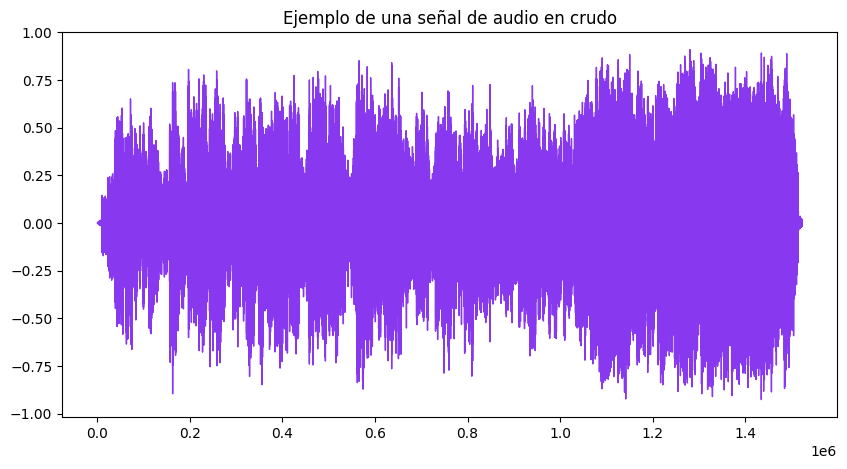

In [13]:
show_audio_signal(y,'Ejemplo de una señal de audio en crudo')

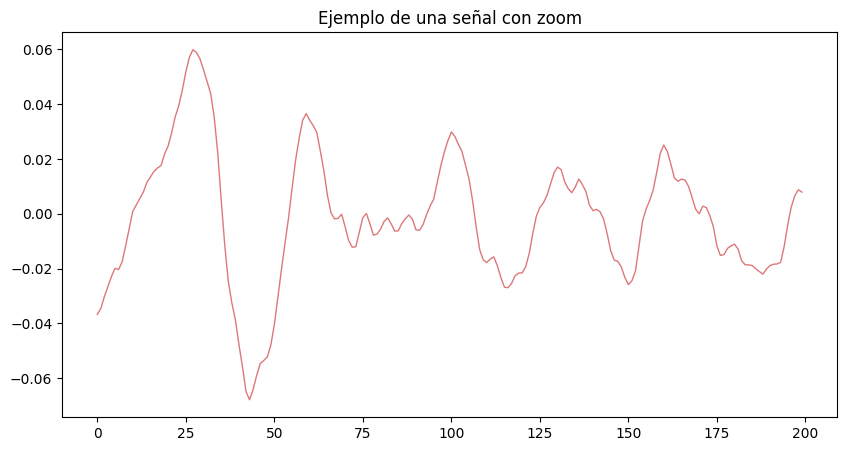

In [14]:
show_audio_signal(audio = pd.Series(y[20000:20200]),
                  title='Ejemplo de una señal con zoom',
                  color='#dd7878')

In [15]:
S_db = get_spectrogram(audio=y)

S_db.shape

(1025, 2974)

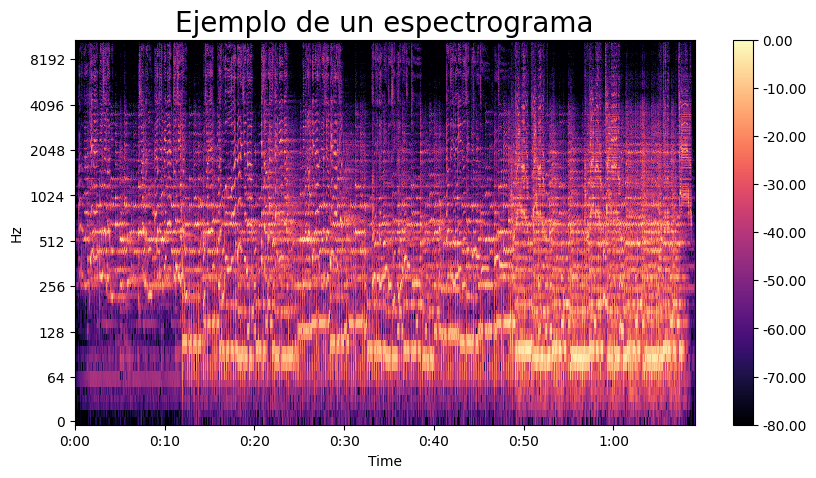

In [16]:
show_spectrogram(S_db,'Ejemplo de un espectrograma')

# Obtener espectrogramas

## Valores por defecto

In [17]:
aux_filenames = pmemo_metadata['fileName']
filenames = [os.path.join(AUDIO_DIR,name) for name in aux_filenames]

print(filenames[0])
print(audio_files[0])



E:\python_proy\mer\assets\PMEMO\PMEmo2019\chorus\1.mp3
E:\python_proy\mer\assets\PMEMO\PMEmo2019\chorus\1.mp3


In [18]:
#Almacenamiento de espectrogramas
spectrograms = []

start_time = time.time()

#Generar y almacenar los espctrogrmas
for audio in filenames:
    y,sr = librosa.load(audio)
    spectrograms.append(get_spectrogram(y))

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Tiempo total transcurrido en la generación de espectrogramas: {elapsed_time:.2f} segundos')

Tiempo total transcurrido en la generación de espectrogramas: 77.80 segundos


### Dimension de los espectrogramas (Frecuencias y Duración)

In [19]:
#Frecuencias del espectrograma
spec_hz = [s.shape[0] for s in spectrograms]
print(f'Media de las frecuencas: {np.mean(spec_hz)}')

print(spectrograms[np.random.randint(0,len(spectrograms))].shape)
print(spectrograms[np.random.randint(0,len(spectrograms))].shape)
print(spectrograms[np.random.randint(0,len(spectrograms))].shape)

Media de las frecuencas: 1025.0
(1025, 1380)
(1025, 1681)
(1025, 2112)


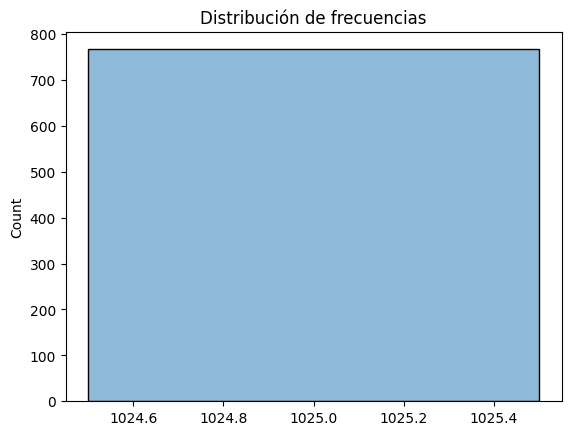

In [20]:
show_distribution(spec_hz,'Distribución de frecuencias')

In [21]:
#Duración de los clips de audio
spec_size = [s.shape[1] for s in spectrograms]
spec_mean = np.mean(spec_size)
spec_std = np.std(spec_size)

print(f'Duracion media: {spec_mean}')
print(f'Duración desviación: {spec_std}')
print(f'Alto: {np.max(spec_size)}')
print(f'Bajo: {np.min(spec_size)}')

Duracion media: 1671.0691003911343
Duración desviación: 586.9379508923892
Alto: 3792
Bajo: 691


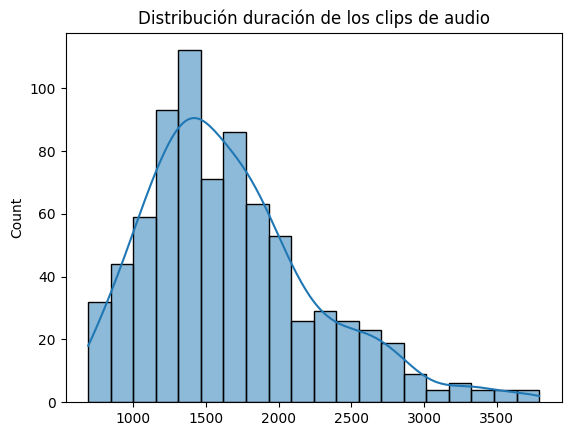

In [22]:
#Distribución de la duración de los clips de audio

show_distribution(spec_size,'Distribución duración de los clips de audio')

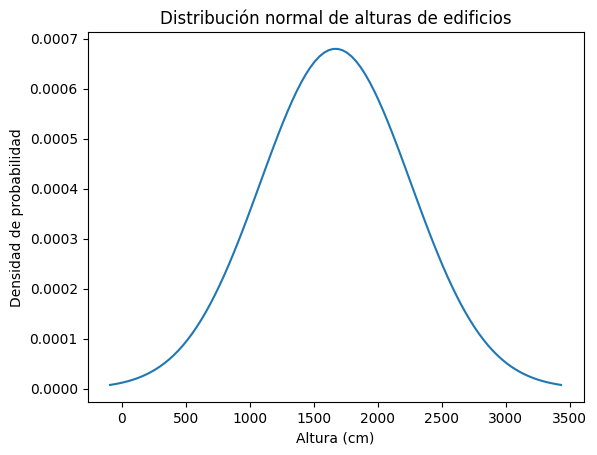

In [23]:
x = np.linspace(spec_mean - 3*spec_std,
                spec_mean + 3*spec_std,
                100)

y = norm.pdf(x,spec_mean,spec_std)


# Crea la gráfica de campana de Gauss

plt.plot(x, y)

plt.xlabel('Altura (cm)')

plt.ylabel('Densidad de probabilidad')

plt.title('Distribución normal de alturas de edificios')

plt.show()

## Downsampling

### vER

In [24]:
random_idx = np.random.randint(low=0,high=len(audio_files))
y,sr = librosa.load(audio_files[random_idx])
print(f'y:{y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y:[-3.9790393e-13 -1.1368684e-13 -1.7053026e-13  1.5631940e-13
  1.4210855e-13 -2.5579538e-13 -3.4106051e-13 -3.4106051e-13
 -1.7053026e-13 -5.6843419e-14]
shape y: (353664,)
sr: 22050


In [25]:

current_song = pmemo_metadata.iloc[random_idx]
display(current_song)


musicId                     761
fileName                761.mp3
title                Greenlight
artist                  Pitbull
album                Greenlight
duration                  35.11
chorus_start_time         02:30
chorus_end_time           03:03
Name: 595, dtype: object

In [26]:
ipd.Audio(audio_files[random_idx])

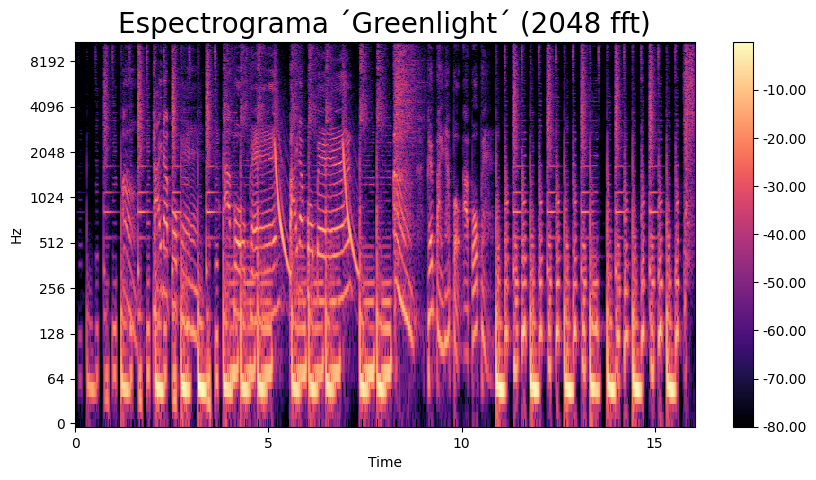

Dimensiones: (1025, 691)


In [27]:
S_db = get_spectrogram(y)

show_spectrogram(S_db,f'Espectrograma ´{current_song[2]}´ (2048 fft)')
print(f'Dimensiones: {S_db.shape}')

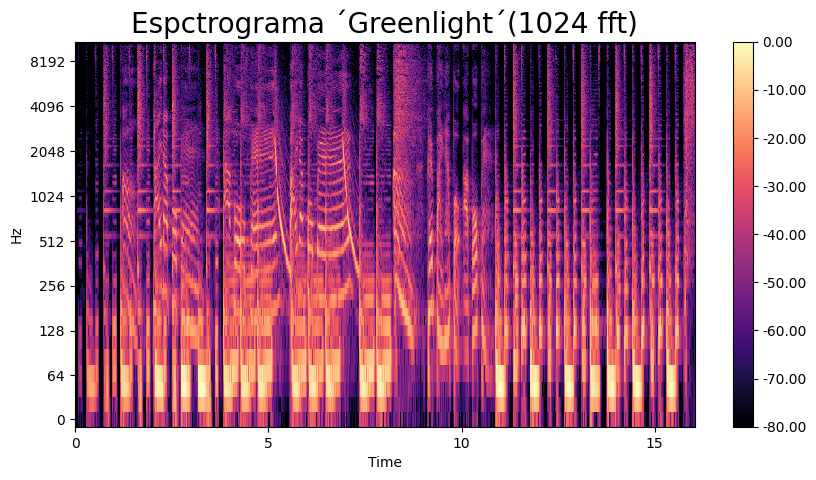

Dimensiones: (513, 691)


In [28]:
S_db2 =get_spectrogram(audio = y,
                       fft_size = 1024,
                       hop_size=512)
show_spectrogram(S_db2,f'Espctrograma ´{current_song[2]}´(1024 fft)')
print(f'Dimensiones: {S_db2.shape}')

### Generar una lista de espectrogramas con down_sampling

In [29]:

spec_down = []
start_time = time.time()
for audio in filenames:
    y,_ = librosa.load(audio)
    spec_down.append(get_spectrogram(audio= y,
                                     fft_size = 1024,
                                     hop_size=512))
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Tiempo total transcurrido en la generación de espectrogramas: {elapsed_time:.2f} segundos')

Tiempo total transcurrido en la generación de espectrogramas: 61.60 segundos


In [30]:
#Frecuencias del espectrograma
spec_hz = [s.shape[0] for s in spec_down]
print(f'Media de las frecuencas: {np.mean(spec_hz)}')

print(spec_down[np.random.randint(0,len(spec_down))].shape)
print(spec_down[np.random.randint(0,len(spec_down))].shape)
print(spec_down[np.random.randint(0,len(spec_down))].shape)

Media de las frecuencas: 513.0
(513, 1079)
(513, 1725)
(513, 1639)


In [31]:
#Duración de los clips de audio
spec_size = [s.shape[1] for s in spec_down]
spec_mean = np.mean(spec_size)
spec_std = np.std(spec_size)

print(f'Duracion media: {spec_mean}')
print(f'Duración desviación: {spec_std}')
print(f'Alto: {np.max(spec_size)}')
print(f'Bajo: {np.min(spec_size)}')

Duracion media: 1671.0691003911343
Duración desviación: 586.9379508923892
Alto: 3792
Bajo: 691


## Padding Spectrograms

In [32]:
spectrograms_padd = []
start_time = time.time()
for s in spectrograms:
    spectrograms_padd.append(adjust_spectrogram(s,int(spec_mean)))

end_time=time.time()
elapsed_time = end_time - start_time
print(f"Tiempo total para paddear los espectrogramas: {elapsed_time:.2f} segundos")

Tiempo total para paddear los espectrogramas: 16.20 segundos


In [33]:
spec_down_padd = []
start_time = time.time()
for s in spec_down:
    spec_down_padd.append(adjust_spectrogram(s,int(spec_mean)))

end_time=time.time()
elapsed_time = end_time - start_time
print(f"Tiempo total para paddear los espectrogramas: {elapsed_time:.2f} segundos")

Tiempo total para paddear los espectrogramas: 3.04 segundos


## Guardar en pickles

In [35]:
save_spectrograms(spectrograms,'spectrograms','')
save_spectrograms(spec_down,'spectrograms_down','')
save_spectrograms(spectrograms_padd,'spectrograms_padd','')
save_spectrograms(spec_down_padd,'spectrograms_down_padd','')

Espectrogramas guardados exitosamente
Espectrogramas guardados exitosamente
Espectrogramas guardados exitosamente
Espectrogramas guardados exitosamente


'spectrograms_down_padd.pkl'